# Tugas Besar IF3270 Pembelajaran Mesin Bag.B

Anggota Kelompok:
1. 13520039 - Rozan Fadhil Al Hafidz
1. 13520054 - Farrel Farandieka Fibriyanto
1. 13520103 - Amar Fadil
1. 13520105 - Malik Akbar Hashemi Rafsanjani

## Teori Dasar

### Gradient Descent

![Gradient Descent](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*P7z2BKhd0R-9uyn9ThDasA.png)

Sumber gambar : [Kapil, D.](https://medium.com/@divakar_239/stochastic-vs-batch-gradient-descent-8820568eada1)

Gradient descent adalah algoritma optimasi yang sering digunakan untuk mencari bobot atau koefisien dalam algoritma pembelajaran mesin, seperti pada artificial neural networks dan logistic regression.

Tujuan dari algoritma ini adalah untuk menemukan parameter model, seperti koefisien atau bobot, yang menghasilkan error minimum pada dataset train. Algoritma ini melakukan perubahan terhadap model dengan menggesernya ke arah yang berlawanan dengan gradien dari fungsi error. Hal ini dilakukan secara berulang-ulang sampai model yang dihasilkan sudah cukup baik. Oleh karena itu, algoritma ini disebut "gradient descent".

Berikut ini adalah variasi dari gradient descent:

#### Stochastic Gradient Descent
Stochastic gradient descent, atau biasa disingkat SGD, adalah variasi dari gradient algoritma gradient descent yang mengkalkulasi error dan mengupdate model untuk setiap data pada dataset training.

#### Batch Gradient Descent
Batch gradient descent adalah variasi dari algoritma gradient descent yang mengkalkulasi error untuk setiap data pada dataset training, tetapi hanya mengupdate model setelah semua data pada dataset training sudah dievaluasi.

Satu siklus mengiterasi seluruh dataset training (disebut sebagai training epoch). Oleh karena itu, batch gradient descent melakukan update model pada akhir setiap training epoch.

#### Mini-Batch Gradient Descent
Mini-batch gradient descent adalah variasi algoritma gradient descent yang membagi dataset training menjadi beberapa batch kecil yang digunakan untuk mengkalkulasi error model dan mengupdate koefisien model.

Mini-batch gradient descent mencari keseimbangan antara robustness dari stochastic gradient descent dan efisiensi dari batch gradient descent. Ini adalah implementasi gradient descent yang paling umum digunakan dalam bidang deep learning.

Sumber: [Brownlee, J.](https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/)


### Perbandingan SGD, BGD, dan MBGD
![Perbandingan](https://miro.medium.com/v2/resize:fit:720/format:webp/1*_ctmL9Ya0DpppDFbiYa7VQ.png)

Sumber gambar : [Sweta](https://sweta-nit.medium.com/batch-mini-batch-and-stochastic-gradient-descent-e9bc4cacd461)

Stochastic gradient descend adalah Mini-batch gradient descend dengan ukuran batch = 1, sedangkan Batch gradient descend adalah Mini-batch gradient descend dengan ukuran batch = jumlah data. Mini-batch gradient descend lebih sering dipilih karena lebih cepat dan lebih stabil dibandingkan dengan stochastic gradient descend karena tidak terlalu sering mengupdate bobot.

Sumber : [Sweta](https://sweta-nit.medium.com/batch-mini-batch-and-stochastic-gradient-descent-e9bc4cacd461)


### Batch Size
Batch size (ukuran batch) mendefinisikan jumlah sampel yang akan dipropagasi melalui network. Contohnya, jika terdapat 1050 data training dan anda akan menggunakan batch_size sebesar 100, maka algoritma akan mengambil 100 sampel pertama (dari sampel ke-1 sampai ke-100) dari data training dan melatih network. Selanjutnya, algoritma akan mengambil 100 sampel kedua (dari sampel ke-101 sampai ke-200) dan melatih network lagi. Hal ini akan terus dilakukan sampai semua sampel telah dipropagasi melalui network.

Keuntungan menggunakan batch size yang lebih kecil dari jumlah semua sampel adalah program memerlukan lebih sedikit memori. Selain itu, biasanya proses pelatihan network akan lebih cepat dengan menggunakan mini-batch. Hal ini dikarenakan bobot akan diupdate setelah setiap propagasi.

Sumber : [Sweta](https://sweta-nit.medium.com/batch-mini-batch-and-stochastic-gradient-descent-e9bc4cacd461)

## Import Libraries

In [50]:
import numpy as np
from typing import Callable, TypedDict
import networkx as nx
import matplotlib.pyplot as plt
import random
from enum import Enum
import pickle
from numpy import log
import json
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import classification_report

## Initiate Program

Kelas activations akan menyimpan fungsi aktivasi yang dapat dipakai oleh kelas neuron. Kelas deltacoef akan menyimpan fungsi untuk perhitungan dalam output layer. Dan kelas deltafuncs akan menyimpan fungsi untuk perhitungan dalam hidden layer.

In [26]:
class activations:
    def softmax(x):
        return np.exp(x)  

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    def relu(x):
        return np.maximum(0, x)

    def sign(x):
        return 1 if x > 0 else -1

    def linear(x):
        return x
    
class deltacoef:
    def linear(o: float):
        return 1

    def relu(o: float):
        if(o < 0):
            return 0
        else:
            return 1

    def sigmoid(o: float):
        return o*(1-o)

    def softmax(o: float):
        return 0

class deltafuncs:
    def linear(expected: float, value: float):
        return -(expected-value)


    def relu(expected: float, value: float):
        if (value < 0):
            return 0
        else:
            return -(expected - value)


    def sigmoid(expected: float, value: float):
        return -value * (1 - value) * (expected - value)


    def softmax(cur_out: float, other_out: float, cur_idx: int, other_idx: int):
        return other_out if (cur_idx != other_idx) else (-1 * (1 - cur_out))


 Kelas ini juga dibantu dengan kelas enum StopReason yang berisi kode pemberhentian training serta kelas enum LayerType yang berisikan kode tipe layer.


In [27]:
class StopReason(Enum):
    MAX_ITERATIONS = 1
    ERROR_THRESHOLD = 2

class LayerType(Enum):
    OUTPUT = 1
    HIDDEN = 2

Terdapat 3 kelas utama yang akan digunakan dalam implementasi: Model, Layer, dan Neuron. 
Ketiga kelas ini dinamakan sesuai dengan entitas yang dipakai pada arsitektur neural network biasanya. Fungsi-fungsi aktivasi yang digunakan akan disimpan di daftar fungsi aktivasi sehingga dapat digunakan oleh kelas neuron.

Kelas neuron akan menyimpan weight yang telah ditetapkan sebelumnya dan menghitung nilai output berdasarkan nilai weight tadi, sebuah fungsi aktivasi, dan nilai masukan yang berasal dari masukan model seluruhnya atau hasil output layer sebelumnya di model. Kelas ini akan menghasilkan suatu value yang menjadi bagian dari output model atau masukan ke layer berikutnya.

Kelas layer akan menyimpan beberapa kelas neuron sehingga membentuk suatu layer penuh. Kelas ini menghasilkan array berupa output neuron yang dimiliki kelas tersebut. Dengan ini, kelas ini bisa menghasilkan nilai yang akan dapat dijadikan masukan layer berikutnya atau, apabila sudah merupakan layer terakhir, menjadi output dari model seluruhnya.

Kelas model akan menyimpan beberapa kelas layer yang dapat dipakai untuk menghitung perhitungan prediksi model tersebut. Kelas model akan menerima nilai masukan dari pengguna dan kemudian mengiterasi dari layer paling awal untuk menghitung nilai keluaran dari layer tersebut untuk kemudian dijadikan parameter untuk layer berikutnya, dan seterusnya sampai sampai ke layer terakhir. Hasil dari layer terakhir akan menjadi hasil output dari model tersebut. Selain itu, kelas ini memiliki method untuk menggambarkan FFNN model tersebut berupa struktur jaringan dan bobotnya baik dalam ilustrasi gambar maupun text. Sebagai tambahan untuk tubes bagian B, kelas ini juga akan memiliki fungsi untuk melakukan mini-batch training yang mana akan dilakukan dengan membagi data training menjadi beberapa batch yang kemudian akan dilakukan training pada setiap batch tersebut, kelas ini kemudian akan meng-update bobot dan bias pada setiap layer berdasarkan hasil training sebelum-sebelumnya.

In [28]:
class Neuron(object):
    def __init__(
        self,
        activation: Callable | str = 'sigmoid',
        weights: list[float] = None,
    ):
        self.activation = activation
        if isinstance(activation, str):
            self.activation: Callable = getattr(activations, activation)
            self.delta_func: Callable = getattr(deltafuncs, activation)
            self.delta_coef: Callable = getattr(deltacoef, activation)
        self.weights = weights
        self.value = 0
        self.delta_err = 0
        self.delta_weights = [0 for _ in range(len(weights))]

    def __call__(self, x: list[float]):
        # feed forward
        val = np.dot(x, self.weights)
        self.value = self.activation(val)
        return self.value

    def __repr__(self):
        return f'Neuron({self.activation.__name__}, {self.weights})'

    def reset_value(self):
        self.value = 0

    def reset_delta_err(self):
        self.delta_err = 0

    def reset_delta_weights(self):
        self.delta_weights = [0 for _ in range(len(self.weights))]
    
    def update_weights(self):
        for i in range(len(self.delta_weights)):
            self.weights[i] += self.delta_weights[i]

class Layer(object):
    def __init__(
        self,
        neurons: list[Neuron] | int,
        name: str = '',
        activation: str = '',
        weights: list[list[float]] = None,
        bias: float = 1,
        input_shape=0,
    ) -> None:
        self.name = name
        if not isinstance(activation, str):
            raise TypeError("activation must be string")
        
        self.activation_type = activation
        self.activation: Callable = getattr(activations, activation)
        self.delta_func: Callable = getattr(deltafuncs, activation)
        self.delta_coef: Callable = getattr(deltacoef, activation)

        self.neurons = neurons
        if isinstance(neurons, int):
            self.neurons: list[Neuron] = [
                Neuron(activation, weights[i] if weights else 0)
                for i in range(neurons)
            ]
        self.bias = bias
        self.input_shape = input_shape

    def get_output_shape(self):
        return len(self.neurons)
    
    def get_values(self):
        return [neuron.value for neuron in self.neurons]

    def get_params_count(self):
        return (self.input_shape + 1) * len(self.neurons) 

    def get_weights(self):
        return np.array([neuron.weights for neuron in self.neurons])

    def __call__(self, inputs: list[float]) -> list[float]:
        # feed forward
        out = [neuron(inputs) for neuron in self.neurons]
        if self.activation is activations.softmax: 
            out = (out / sum(out)).tolist()
        for i in range(len(out)):
            self.neurons[i].value = out[i]
        return out

    def __repr__(self):
        activation_name = self.activation.__name__
        weights = self.get_transformed_weights()
        param_count = self.get_params_count()

        return ''.join([
            'Layer(',
            f'activation={activation_name},',
            f'weights={weights},',
            f'bias={self.bias},',
            f'param_count={param_count}',
            ')',
        ])
    
    def reset_value(self):
        for neuron in self.neurons:
            neuron.reset_value()

    def reset_delta_err(self):
        for neuron in self.neurons:
            neuron.reset_delta_err()
        
    def reset_delta_weights(self):
        for neuron in self.neurons:
            neuron.reset_delta_weights()

    def calc(self, type: LayerType, prev_values: list[float], learning_rate: float, expected: list[float] = [], next_neurons: list[Neuron] = None):
        if (type == LayerType.OUTPUT):
            for j in range(len(self.neurons)):
                neuron = self.neurons[j]

                if (self.activation_type == 'softmax'):
                    neuron.reset_delta_err()
                    cur_out = neuron.value
                    for k in range(len(self.neurons)):
                        other_out = self.neurons[k].value
                        delta_val = self.delta_func(cur_out, other_out, j, k) * expected[k]
                        neuron.delta_err += delta_val
                else:
                    neuron.delta_err = self.delta_func(expected[j], neuron.value)

                for k, _ in enumerate(neuron.delta_weights): 
                    neuron.delta_weights[k] += -learning_rate * neuron.delta_err * prev_values[k]
        elif (type == LayerType.HIDDEN):
            for j in range(len(self.neurons)):
                neuron = self.neurons[j]
                sum = 0
                for k in range(len(next_neurons)):
                    next_neuron = next_neurons[k]
                    sum += next_neuron.delta_err * next_neuron.weights[j]
                neuron.delta_err = self.delta_coef(neuron.value) * sum
                for k in range(len(neuron.delta_weights)):
                    neuron.delta_weights[k] += -learning_rate * neuron.delta_err * prev_values[k]

    def update_weights(self):
        for i in range(len(self.neurons)):
            self.neurons[i].update_weights()

        
    def get_transformed_weights(self):
        weights = self.get_weights()
        bias = [b[-1] for b in weights]
        weights = [w[:-1] for w in weights]
        weights = [list(x) for x in zip(*weights)]
        transformed_weights = [bias]
        transformed_weights.extend(weights)

        rounded = [[round(x1, 4) for x1 in x] for x in transformed_weights]
        return rounded

class Model(object):
    def __init__(self, layers: list[Layer] = None,
        learning_rate: float = 0.1,
        batch_size: int = 10,
        max_iterations: int = 100,
        error_threshold: float = 0.1,
    ) -> None:
        self.layers = layers
        if layers is None:
            self.layers: list[Layer] = []
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.max_iteration = max_iterations
        self.error_threshold = error_threshold

    def add(self, layer: Layer) -> None:
        if self.layers:
            layer.input_shape = self.layers[-1].get_output_shape()
        self.layers.append(layer)

    def get_params_count(self):
        return sum([layer.get_params_count() for layer in self.layers])

    def summary(self):
        print(f'Model with {self.get_params_count()} parameters')
        print(f'Learning rate={self.learning_rate}')
        print(f'Batch size={self.batch_size}')
        print(f'Max iteration={self.max_iteration}')
        print(f'Error threshold={self.error_threshold}')
        for layer in self.layers:
            print(layer)

    def draw(self):
        graph = nx.DiGraph()

        # draw input layer
        num_inputs = self.layers[0].input_shape
        for i in range(num_inputs):
            graph.add_node(f'i_{i}', color='green', pos=(0,-i))

        # draw hidden layers
        for i, layer in enumerate(self.layers):
            graph.add_node(f'b_{i}', color='black', pos=(i + 0.25, -layer.input_shape))
            for j, neuron in enumerate(layer.neurons):
                color = 'blue' if i < len(self.layers) - 1 else 'red'
                cur_node = f'h_{i}_{j}' if i < len(self.layers) - 1 else f'o_{j}'
                graph.add_node(cur_node, color=color, pos=(i+1, -j + random.randrange(-3, 3) * 0.1))

                for k, weight in enumerate(neuron.weights):
                    src = f'b_{i}' if k == len(neuron.weights) - 1 else (f'i_{k}' if i == 0 else f'h_{i-1}_{k}')
                    graph.add_edge(src, cur_node, weight=weight)
            
        # draw graph
        pos = nx.get_node_attributes(graph, 'pos')
        edge_labels = nx.get_edge_attributes(graph, 'weight')

        # make plot bigger
        plot = plt.gca()
        plot.figure.set_size_inches(10, 10)
        plot.set_title('Feed Forward Neural Network Model')

        nx.draw(graph, pos, with_labels=True, node_color=[graph.nodes[node].get('color') for node in graph.nodes], node_size=1000, font_size=8, font_color='white', ax=plot)
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8, ax=plot)


    def single_predict(self, input: list[float]):
        out = list(input)
        for layer in self.layers:
            out.append(1)
            out = layer(out)
        return out

    def __call__(self, inputs: list[list[float]]):
        # feed forward
        outputs: list[list[float]] = []
        for input in inputs:
            out = list(input)
            for layer in self.layers:
                out.append(1)
                out = layer(out)
            outputs.append(out)

        return outputs

    def get_prev_values(self, idx: int, inputs: list[float]):
        bias = 1
        if idx == 0:
            return list(inputs.copy()) + [bias]
        else:
            return self.layers[idx-1].get_values() + [bias]

    def propagate(self, inputs: list[float], expected: list[float], learning_rate: float):
        _ = self.single_predict(inputs)

        num = len(self.layers)
        for i in range(num-1, -1, -1):
            layer = self.layers[i]
            prev_layer_values = self.get_prev_values(i, inputs)
            if (i == (num-1)): # output layer
                layer.calc(LayerType.OUTPUT, prev_layer_values, learning_rate, expected)
            else:
                next_layer = self.layers[i+1]
                layer.calc(LayerType.HIDDEN, prev_layer_values, learning_rate, None, next_layer.neurons)

    def reset_value(self):
        for layer in self.layers:
            layer.reset_value()
    
    def reset_delta_err(self):
        for layer in self.layers:
            layer.reset_delta_err()

    def reset_delta_weights(self):
        for layer in self.layers:
            layer.reset_delta_weights()

    def multi_propagates(self, inputs: list[list[float]], expected: list[list[float]], learning_rate: float):
        num = len(inputs)
        for i in range(num):
            self.propagate(inputs[i], expected[i], learning_rate)
            self.reset_value()
            self.reset_delta_err()

    def update_weights(self):
        for i in range(len(self.layers)):
            layer = self.layers[i]
            layer.update_weights()

    def calc_total_err(self, inputs: list[list[float]], expected: list[list[float]]):
        res = self(inputs)

        total_err = 0
        flag_softmax = self.layers[-1].activation_type == 'softmax'
        for i in range(len(res)):
            if (flag_softmax):
                for j1 in range(len(res[0])):
                    total_err += -(expected[i][j1] * log(res[i][j1]))
            for j in range(len(res[i])):
                total_err += 0.5 * (res[i][j] - expected[i][j]) ** 2
        return total_err

    def fit(
        self, 
        inputs: list[list[float]], 
        expected: list[list[float]],
    ):
        num = len(inputs)
        for i in range(self.max_iteration):
            # permut = [i for i in range(num)]
            permut = np.random.permutation(num)
            for j in range(0, num, self.batch_size):
                bound = min(j + self.batch_size, num)
                batch_indices = permut[j:bound]

                cur_inputs = [inputs[i] for i in batch_indices]
                cur_expected = [expected[i] for i in batch_indices]

                self.multi_propagates(cur_inputs, cur_expected, self.learning_rate)
                self.update_weights()
                self.reset_delta_weights()
            total_err = self.calc_total_err(inputs, expected)
            # print(f'Iteration {i+1}: {total_err}')
            if total_err < self.error_threshold:
                return StopReason.ERROR_THRESHOLD
        return StopReason.MAX_ITERATIONS

    def save(self, path: str):
        with open(path, 'wb') as f:
            pickle.dump(self, f)

Kelas JsonReader bertanggung jawab untuk membaca file json. Dengan kelas ini, program dapat me-load model-model yang telah ditetapkan di file json eksternal.

In [29]:
class JsonReader:
    def __init__(self, filename: str):
        self.filename = filename
        self.data = None

    def read(self):
        with open(self.filename, 'r') as f:
            self.data = json.load(f)
        return self.data

    def get(self, index: int| str):
        return self.data[index]

    def length(self):
        return len(self.data)

ModelConfig adalah kelas model yang bertugas menyimpan konfigurasi model yang akan digunakan dengan struktur data yang telah ditentukan oleh asisten.

In [30]:
class Layers(TypedDict):
    number_of_neurons: int
    activation_function : str

class ModelData(TypedDict):
    input_size: int
    layers: Layers

class LearningParameters(TypedDict): 
    learning_rate: float
    batch_size: int
    max_iteration: int
    error_threshold: float

class Case(TypedDict):
    model: ModelData
    input: list[list[list[float]]]
    initial_weights: list[list[list[float]]]
    target: list[list[list[float]]]
    learning_parameters: LearningParameters

class Expect(TypedDict):
    stopped_by: str
    final_weights: list[list[list[float]]]


class ModelConfig(TypedDict):
    case: Case
    expect: Expect


Kelas JsonParser bertanggung jawab untuk mem-parse file json dengan format yang ditentukan oleh asisten. Dengan kelas ini, program dapat mem-parse model-model yang telah ditetapkan di file json eksternal.

In [31]:
class JsonParser:
    def parse_model_config(self, json_path: str) -> ModelConfig:
        model_config: ModelConfig = JsonReader(json_path).read()
        return model_config

ModelFactory adalah kelas yang bertugas untuk membuat model berdasarkan konfigurasi dari ModelConfig. Selain itu, kelas ini juga bisa me-load model dari file eksternal.

In [32]:
class ModelFactory:
    def build(self, model_config: ModelConfig) -> Model:
        case = model_config["case"]
        learning_parameters = case["learning_parameters"]
        model = Model(
            learning_rate=learning_parameters["learning_rate"],
            batch_size=learning_parameters["batch_size"],
            max_iterations=learning_parameters["max_iteration"],
            error_threshold=learning_parameters["error_threshold"]
        )
        for i in range(len(case["model"]["layers"])):
            layer = case["model"]["layers"][i]
            weights = case["initial_weights"][i][1:]
            weights = [list(x) for x in zip(*weights)]
            for j in range(len(weights)):
                weights[j].append(case["initial_weights"][i][0][j])
            model.add(Layer(
                layer["number_of_neurons"],
                input_shape=case["model"].get('input_size'),
                activation=layer['activation_function'],
                weights=weights,
                bias=1,
            ))
        return model
    
    def load(self, path: str) -> Model:
        with open(path, 'rb') as f:
            return pickle.load(f)


Kelas tambahan berupa model_tester untuk mengetes model dengan fail testcase asisten. 

In [33]:
class model_tester:
    @staticmethod
    def test(test_case: str):
        model_config: ModelConfig = JsonParser().parse_model_config(test_case)
        model_factory = ModelFactory()
        model = model_factory.build(model_config)

        data = model_config['case']['input']
        target = model_config['case']['target']

        stop_reason = model.fit(data, target)
        print("===================================================")
        model.summary()
        print("Expected final weights:",
            model_config['expect'].get("final_weights"))

        print("===================================================")
        if (stop_reason == StopReason.MAX_ITERATIONS):
            print('Stop reason: max_iterations')
        elif (stop_reason == StopReason.ERROR_THRESHOLD):
            print('Stop reason: error_threshold')

        print("Expected stop reason: ", model_config['expect']['stopped_by'])
        model.draw()

## Pengujian

sse_only

Model with 4 parameters
Learning rate=0.01
Batch size=1
Max iteration=10000
Error threshold=0.25
Layer(activation=linear,weights=[[0.495, 0.505], [0.0, 0.0]],bias=1,param_count=4)
Expected final weights: [[[0.5, 0.5], [0.0, 0.0]]]
Stop reason: error_threshold
Expected stop reason:  error_threshold


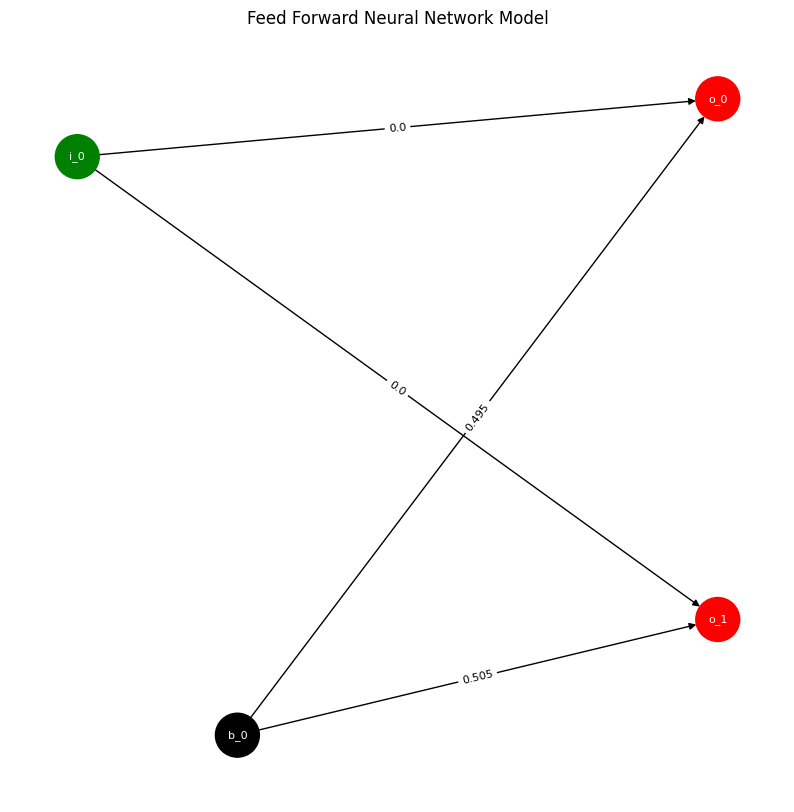

In [34]:
model_name = 'test/sse_only.json'
model_tester.test(model_name)

softmax

Model with 6 parameters
Learning rate=0.1
Batch size=2
Max iteration=1
Error threshold=0.0
Layer(activation=softmax,weights=[[0.1351, 0.2351], [0.3065, -0.4435], [0.776, 0.726]],bias=1,param_count=6)
Expected final weights: [[[0.11301357, 0.18698643], [0.29539055, -0.39539055], [0.79810267, 0.70189733]]]
Stop reason: max_iterations
Expected stop reason:  max_iteration


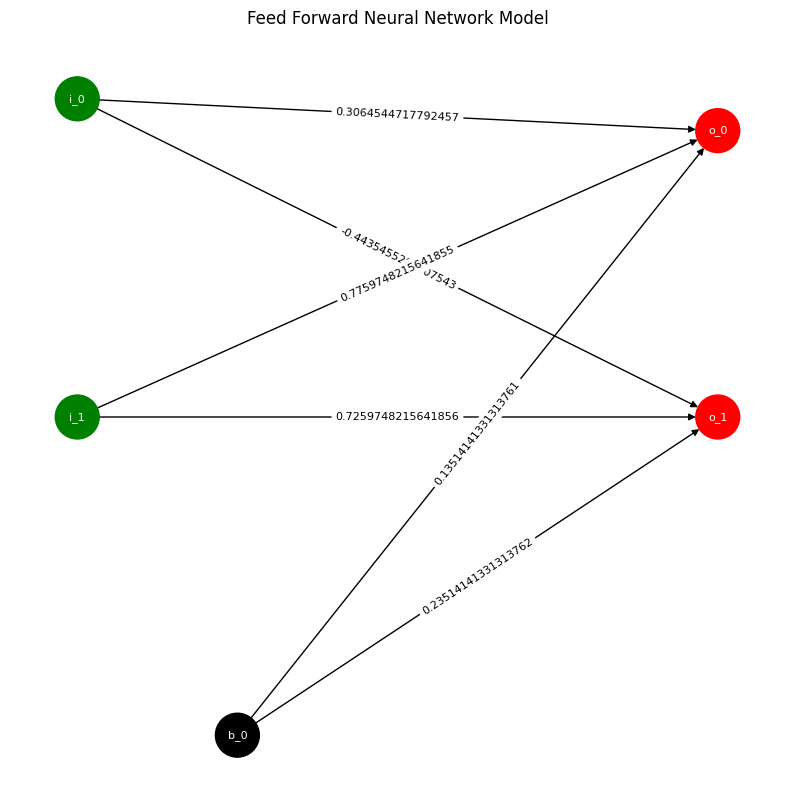

In [35]:
model_name = 'test/softmax.json'
model_tester.test(model_name)

softmax_error_only

Model with 4 parameters
Learning rate=0.1
Batch size=1
Max iteration=1
Error threshold=0.225
Layer(activation=softmax,weights=[[0.3198, 0.7198], [0.2802, -0.9198]],bias=1,param_count=4)
Expected final weights: [[[0.4, 0.7], [0.2, -0.9]]]
Stop reason: error_threshold
Expected stop reason:  error_threshold


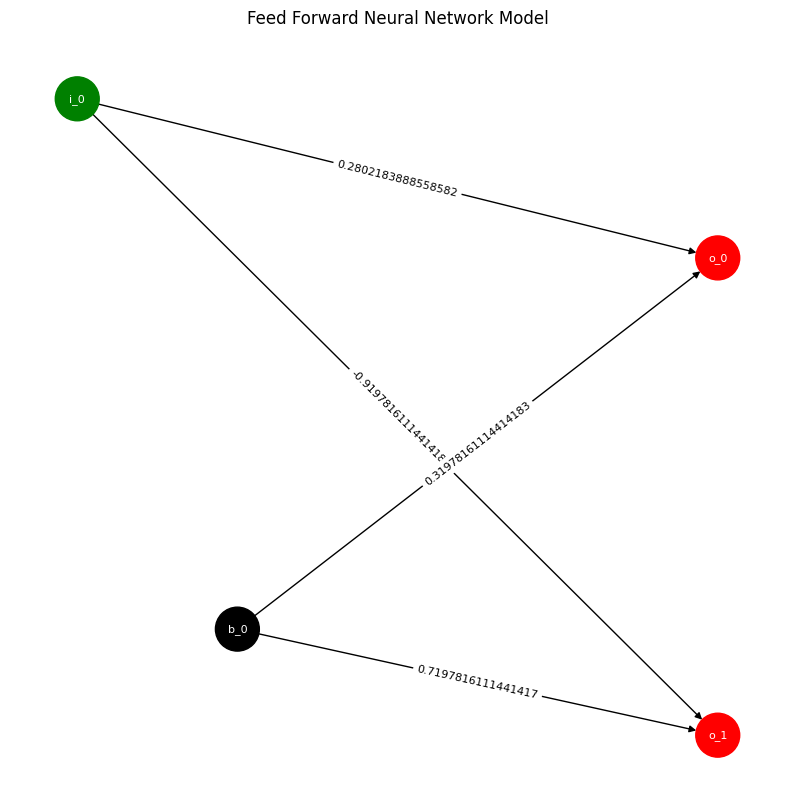

In [36]:
model_name = 'test/softmax_error_only.json'
model_tester.test(model_name)

sigmoid

Model with 6 parameters
Learning rate=0.1
Batch size=2
Max iteration=1
Error threshold=0.1
Layer(activation=sigmoid,weights=[[0.1006, 0.1975], [0.4, 0.5], [0.9011, 0.0986]],bias=1,param_count=6)
Expected final weights: [[[0.7125, -1.1742], [2.3583, -0.2848], [0.1112, -1.1396]]]
Stop reason: max_iterations
Expected stop reason:  max_iteration


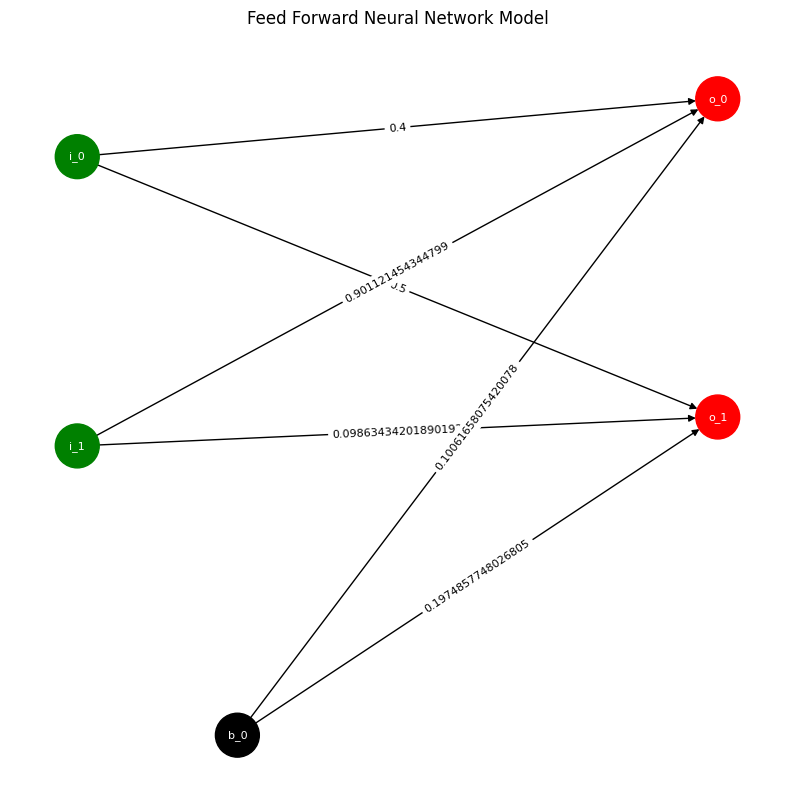

In [37]:
model_name = 'test/sigmoid.json'
model_tester.test(model_name)

sigmoid_stochastic_GD

Model with 6 parameters
Learning rate=0.1
Batch size=2
Max iteration=10000
Error threshold=0.2
Layer(activation=sigmoid,weights=[[0.458, 0.653], [1.5592, 3.2005], [-4.0352, -13.0524]],bias=1,param_count=6)
Expected final weights: None
Stop reason: max_iterations
Expected stop reason:  error_threshold


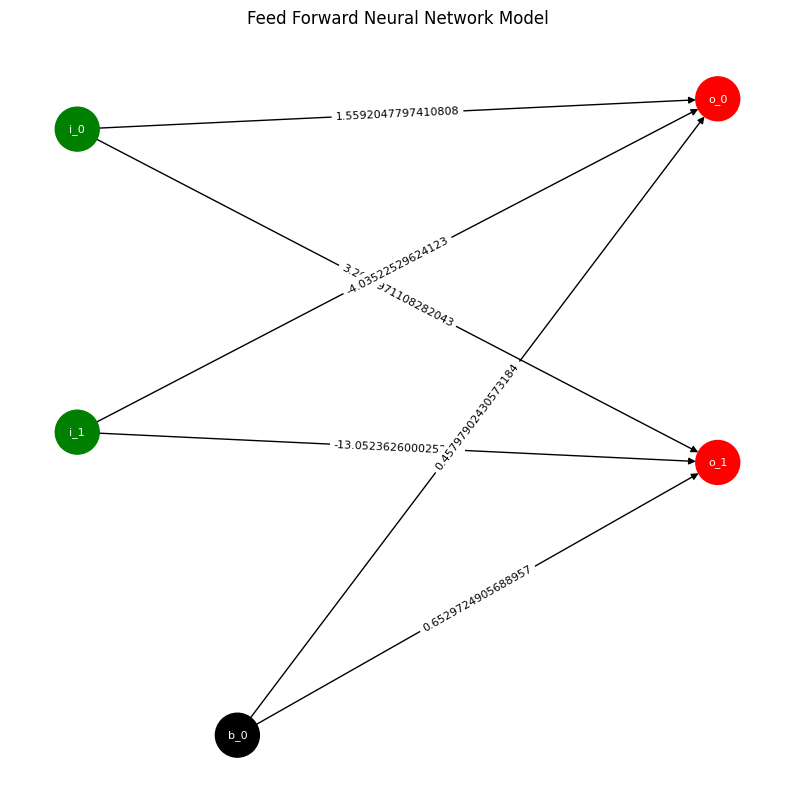

In [38]:
model_name = 'test/sigmoid_stochastic_GD.JSON'
model_tester.test(model_name)

sigmoid_mini_batch_GD

Model with 6 parameters
Learning rate=0.1
Batch size=2
Max iteration=10000
Error threshold=0.2
Layer(activation=sigmoid,weights=[[0.4585, 0.6527], [1.5592, 3.2006], [-4.0347, -13.0523]],bias=1,param_count=6)
Expected final weights: None
Stop reason: max_iterations
Expected stop reason:  error_threshold


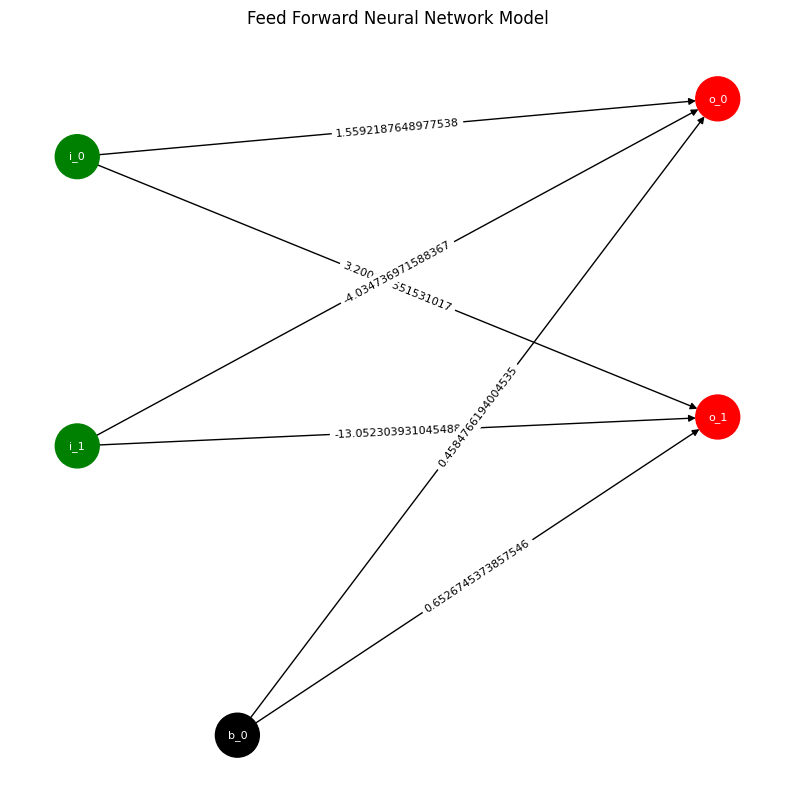

In [40]:
model_name = 'test/sigmoid_mini_batch_GD.JSON'
model_tester.test(model_name)

relu

Model with 9 parameters
Learning rate=0.1
Batch size=2
Max iteration=1
Error threshold=0.0
Layer(activation=relu,weights=[[0.115, 0.2, 0.26], [0.4, -0.485, 0.565], [0.6925, 0.785, -0.845]],bias=1,param_count=9)
Expected final weights: [[[0.105, 0.19, 0.25], [0.395, -0.49, 0.575], [0.7025, 0.795, -0.85]]]
Stop reason: max_iterations
Expected stop reason:  max_iteration


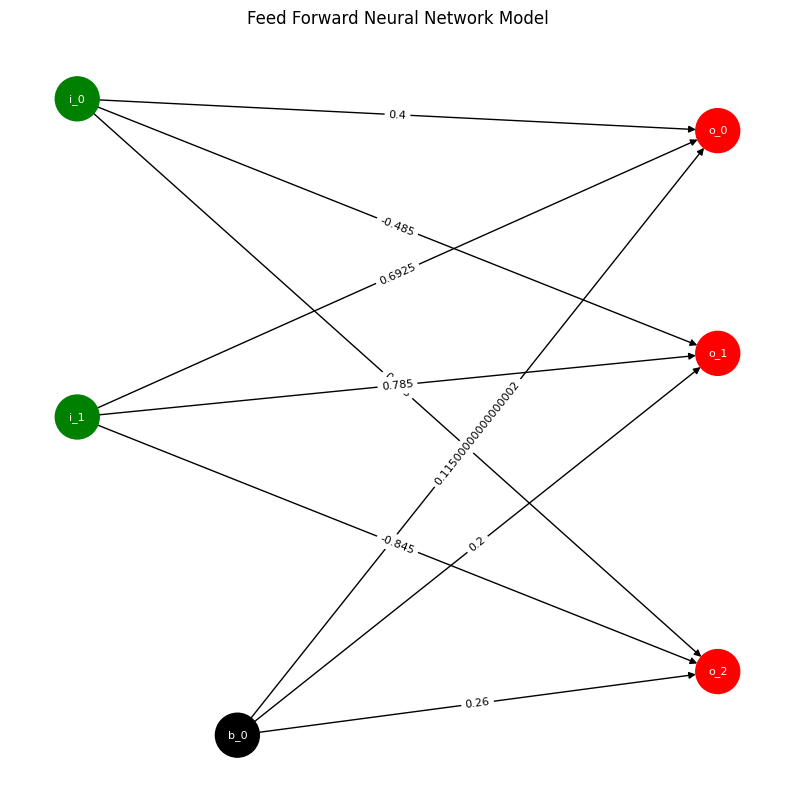

In [41]:
model_name = 'test/relu.json'
model_tester.test(model_name)

mlp

Model with 12 parameters
Learning rate=0.1
Batch size=2
Max iteration=1
Error threshold=0.0
Layer(activation=linear,weights=[[0.1062, 0.2183], [0.4464, -0.4013], [0.6506, 0.6922]],bias=1,param_count=6)
Layer(activation=relu,weights=[[0.121, 0.2045], [0.3561, -0.5043], [0.5281, 0.7854]],bias=1,param_count=6)
Expected final weights: [[[0.07115, 0.1403], [0.42885, -0.4403], [0.685575, 0.77015]], [[0.121, 0.2045], [0.35605, -0.504275], [0.5281, 0.78545]]]
Stop reason: max_iterations
Expected stop reason:  max_iteration


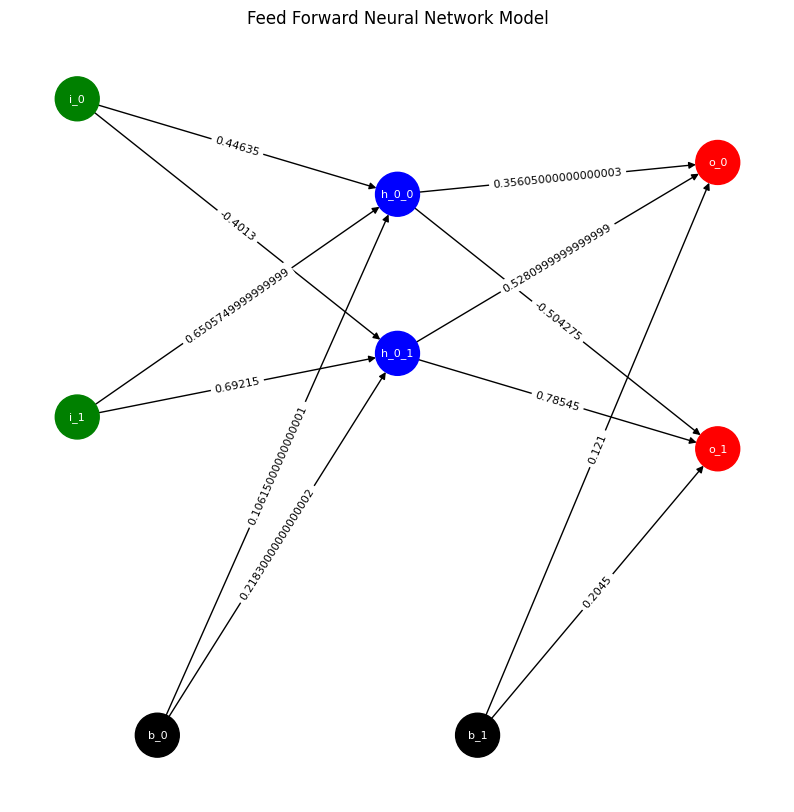

In [42]:
model_name = 'test/mlp.json'
model_tester.test(model_name)

linear

Model with 9 parameters
Learning rate=0.1
Batch size=2
Max iteration=1
Error threshold=0.0
Layer(activation=linear,weights=[[0.22, 0.36, 0.11], [0.64, 0.3, -0.89], [0.28, -0.7, 0.37]],bias=1,param_count=9)
Expected final weights: [[[0.22, 0.36, 0.11], [0.64, 0.3, -0.89], [0.28, -0.7, 0.37]]]
Stop reason: max_iterations
Expected stop reason:  max_iteration


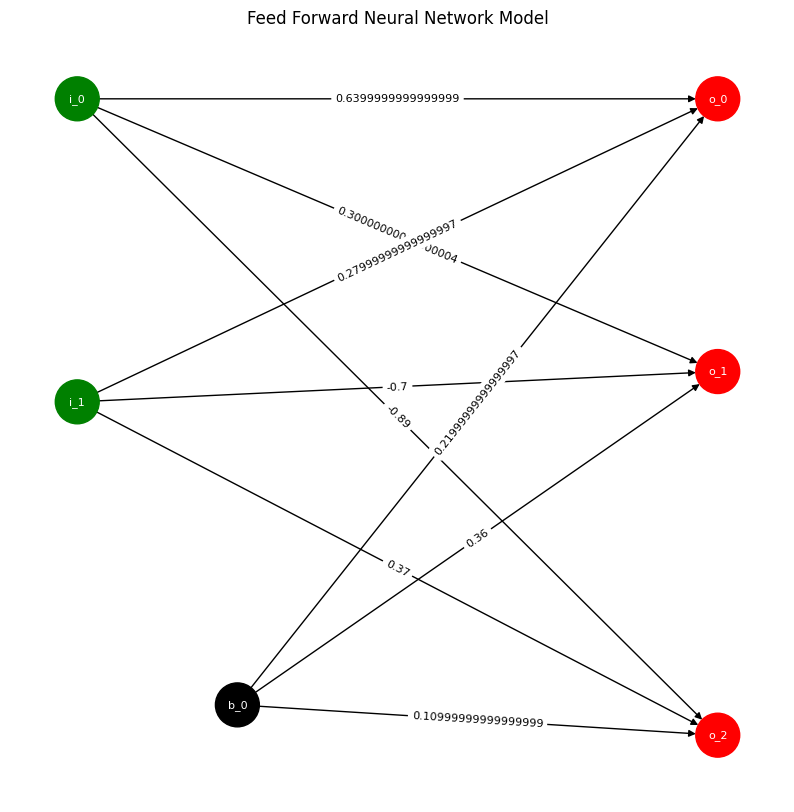

In [43]:
model_name = 'test/linear.json'
model_tester.test(model_name)

linear_two_iteration

Model with 9 parameters
Learning rate=0.1
Batch size=2
Max iteration=2
Error threshold=0.0
Layer(activation=linear,weights=[[0.166, 0.338, 0.153], [0.502, 0.226, -0.789], [0.214, -0.718, 0.427]],bias=1,param_count=9)
Expected final weights: [[[0.166, 0.338, 0.153], [0.502, 0.226, -0.789], [0.214, -0.718, 0.427]]]
Stop reason: max_iterations
Expected stop reason:  max_iteration


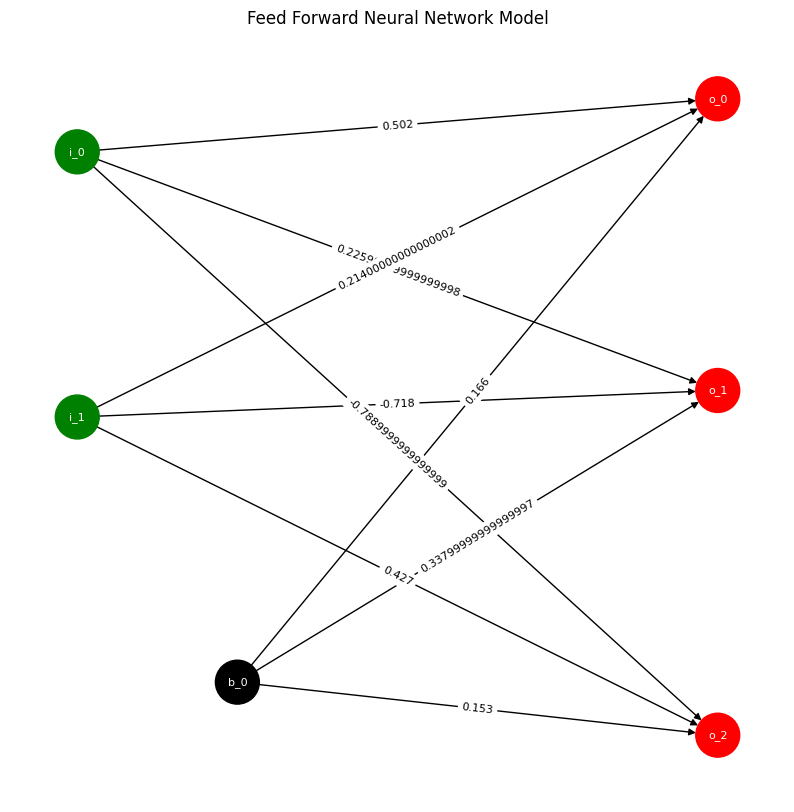

In [44]:
model_name = 'test/linear_two_iteration.json'
model_tester.test(model_name)

linear_small_lr

Model with 9 parameters
Learning rate=0.001
Batch size=2
Max iteration=1
Error threshold=0.0
Layer(activation=linear,weights=[[0.1012, 0.3006, 0.1991], [0.4024, 0.201, -0.7019], [0.1018, -0.799, 0.4987]],bias=1,param_count=9)
Expected final weights: [[[0.1008, 0.3006, 0.1991], [0.402, 0.201, -0.7019], [0.101, -0.799, 0.4987]]]
Stop reason: max_iterations
Expected stop reason:  max_iteration


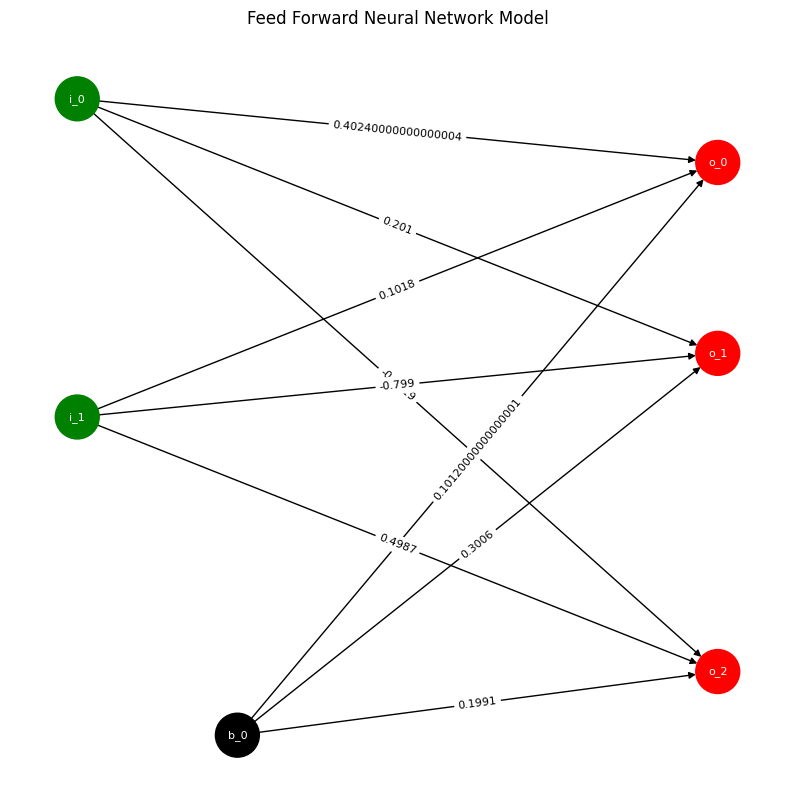

In [45]:
model_name = 'test/linear_small_lr.json'
model_tester.test(model_name)

## Perbandingan dengan SKLearn MLPClassifier

/home/noxira/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


StopReason.ERROR_THRESHOLD
report_sklearn
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45

report_model
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



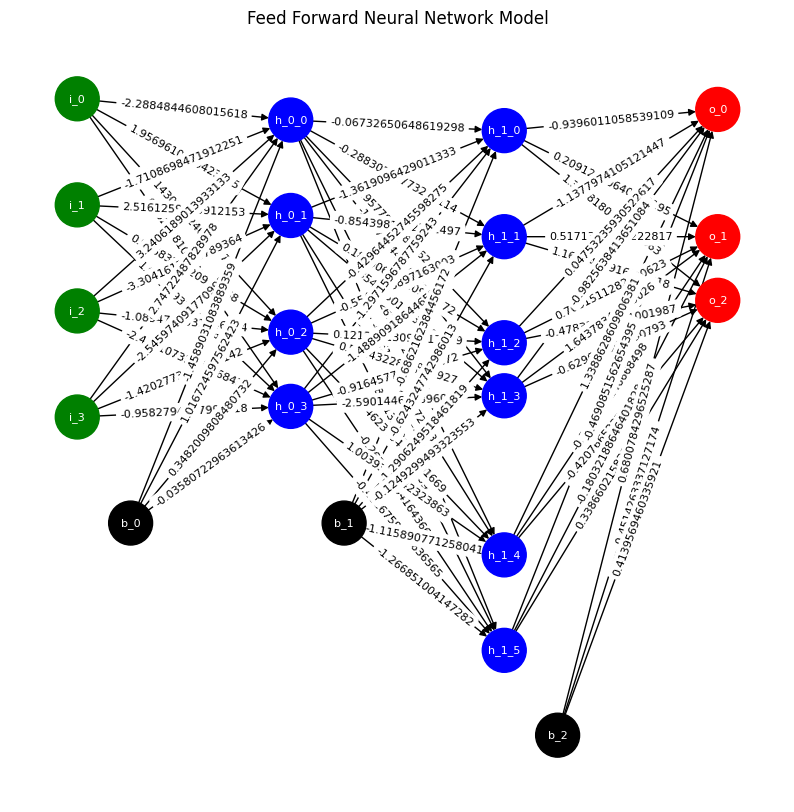

In [56]:
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

X_train, X_val, y_train, y_val = train_test_split(X_iris, y_iris, test_size=0.3, random_state=42)

model_iris_sklearn = MLPClassifier(hidden_layer_sizes=(
    4,), activation="relu", learning_rate_init=0.0025, batch_size=8, max_iter=1000, verbose=False, solver="sgd", momentum=0)

model_iris_sklearn.fit(X_train, y_train)

prediction = model_iris_sklearn.predict(X_val) 

report_sklearn = classification_report(y_val, prediction)

mlp_scratch = Model(learning_rate=0.1, max_iterations=1000,
                    batch_size=4, error_threshold=3)

mlp_scratch.add(
    Layer(input_shape=4, neurons=4, 
            activation='sigmoid',
            weights=[[(random.random() - 0.5) for _ in range(5)] for _ in range(4)]))
mlp_scratch.add(
    Layer(neurons=6,
            activation='sigmoid',
            weights=[[(random.random() - 0.5) for _ in range(5)] for _ in range(6)]))
mlp_scratch.add(
    Layer(neurons=3, 
            activation='linear',
            weights=[[(random.random() - 0.5) for _ in range(7)] for _ in range(3)]))

y = [[1 if t == i else 0 for i in range(3)] for t in y_train]
stop_reason = mlp_scratch.fit(X_train, y)
print(stop_reason)

res = mlp_scratch(X_val)
idx_max = [i.index(max(i)) for i in res]

report_model = classification_report(y_val, idx_max)

print("report_sklearn")
print(report_sklearn)

print("report_model")
print(report_model)

mlp_scratch.draw()
